In [1]:
import numpy as np
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from pyomo.environ import Constraint
import logging

In [2]:
%matplotlib inline
logging.basicConfig(level="INFO")

## Δεδομένα Παραγωγής και Κατανάλωσης

In [3]:
data=pd.read_csv("time_series_60min_singleindex.csv", parse_dates=True)
data.set_index(['utc_timestamp'], inplace=True)
gr_cols = [col for col in data.columns if col.startswith('GR_')]
data=data[gr_cols]
data=data['2015-01-01':'2020-09-30']
data=data.fillna(method='pad')
data=data.fillna(method='backfill')
data_load=data['GR_load_actual_entsoe_transparency']/2000 #Υποθετω οτι ειναι για 10.000.000/2.000 = 5.000 άτομα
data_pvprod=data['GR_solar_generation_actual']/(2115/5)   #Pmax=5MW όσο και το μέγιστο φορτίο

In [4]:
data_load.describe()

count    50376.000000
mean         2.910121
std          0.564945
min          1.504880
25%          2.480803
50%          2.884853
75%          3.297722
max          4.874310
Name: GR_load_actual_entsoe_transparency, dtype: float64

In [5]:
data_pvprod.describe()

count    50376.000000
mean         0.991647
std          1.361433
min          0.000000
25%          0.000000
50%          0.037825
75%          1.964539
max          5.000000
Name: GR_solar_generation_actual, dtype: float64

## Προσομοίωση Δικτύου

In [6]:
network = pypsa.Network()
network.set_snapshots(data.index)

In [7]:
#Add buses and carriers to the network
network.add("Bus", "Diesel", carrier='AC')
network.add("Carrier", "diesel",co2_emissions=0) #1.1 tonnes/MWh

network.add("Carrier", "solar")

network.add("Bus", "Solar", carrier="AC")

#Add lines
network.add("Line","Line",bus0="Diesel",bus1="Solar", r=0.01, x=0.1, s_nom_extendable=True)

#Add generators
network.add(
    "Generator",
    "Diesel Gen",
    bus="Diesel",
    carrier="diesel",
    p_nom=5, 
    p_nom_extendable=False,
    p_min_pu=0.3, 
    control="Slack",
    capital_cost=0, 
    marginal_cost=500,
    )

network.add(
    "Generator",
    "PV Park",
    bus="Solar", 
    carrier="solar",
    control="PV", 
    p_nom=1, #MW 
    p_nom_extendable=False,
    p_max_pu=np.array(data_pvprod),
    capital_cost=0,
    marginal_cost=24
)

#Add loads
network.add("Load", "load 1", bus="Solar", p_set=np.array(data_load)) 

## Προσωμοίωση Power to Gas  

In [8]:
network.add("Bus", "Hydrogen", carrier="hydrogen")

network.add("Carrier", "hydrogen")
network.add("Carrier", "electrolysis")
network.add("Carrier", "fuel cell")

#Add electrolysis and fuel cell links
network.add(
    "Link",
    "Electrolysis",
    bus0="Solar",
    bus1="Hydrogen",
    carrier="electrolysis",
    efficiency=0.7, 
    p_nom=2.5, #Limit of active power which can pass through link. 
    p_nom_extendable=True, 
    #p_min_pu=0.2,
    #p_max_pu=1, 
    capital_cost=350000/5, #Capital cost of extending p_nom by 1 MW (€/MW)
    marginal_cost=30,
    )    

network.add(
    "Link",
    "Fuel Cell",
    bus0="Hydrogen",
    bus1="Solar",
    carrier="fuel cell",
    efficiency=0.6, 
    p_nom=1.2, #Limit of active power which can pass through link. 
    #p_min_pu=0.2,    
    #p_max_pu=1, 
    p_nom_extendable=True,
    capital_cost=350000/5,	#Capital cost of extending p_nom by 1 MW (€/MW)
    marginal_cost=30,
    )

#Add H2 store 
network.add(
    "Store", 
    "H2", 
    bus="Hydrogen", 
    carrier="hydrogen", 
    e_nom=15, #Nominal energy capacity (MWh)
    e_cyclic=True, 
    e_nom_extendable=True,
    capital_cost=30000/5,  #Capital cost of extending p_nom by 1 MW (€/MWh)
    marginal_cost=10,   
    )

#network.add("Load", "load 2", bus="Hydrogen", p_set=0.3)


## Ροη φορτιου και βελτιστοποιηση
Χρησιμοποείται η εντολή network.optimize() για να τρέξει το σύστημα και να βελτιστοποιηθεί το αποτέλεσμα. Ο χρόνος εκτέλεσης ειναι 34min 35sec.

In [9]:
network.optimize(network.snapshots, solver_name="glpk", solver_options={})

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io:Writing objective.
Writing variables.: 100%|██████████| 9/9 [00:01<00:00,  8.73it/s]
INFO:linopy.io: Writing time: 6.02s


GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --lp C:\Users\2F06~1\AppData\Local\Temp\linopy-problem-rbp17dt1.lp --output
 C:\Users\2F06~1\AppData\Local\Temp\linopy-solve-kak7c46_.sol
Reading problem data from 'C:\Users\2F06~1\AppData\Local\Temp\linopy-problem-rbp17dt1.lp'...
806020 rows, 352637 columns, 1460908 non-zeros
5289530 lines were read
GLPK Simplex Optimizer, v4.65
806020 rows, 352637 columns, 1460908 non-zeros
Preprocessing...
352632 rows, 251884 columns, 856392 non-zeros
Scaling...
 A: min|aij| =  6.000e-01  max|aij| =  1.000e+00  ratio =  1.667e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 352631
      0: obj =   5.218210349e+07 inf =   1.155e+05 (63437)
    335: obj =   5.218210349e+07 inf =   3.219e+04 (35486) 3
    663: obj =   5.218210349e+07 inf =   3.054e+04 (35141) 3
    997: obj =   5.218210349e+07 inf =   2.957e+04 (34778) 3
   1335: obj =   5.218210349e+07 inf =   2.880e+04 (34408

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 352637 primals, 806020 duals
Objective: 5.60e+07
Solver model: not available
Solver message: optimal



('ok', 'optimal')

## Αποτελέσματα και Σχόλια
Παρακάτω εμφανίζονται τα δεδομένα της βελτιστοποίησης οπως είναι: το objective function, το μονογραμμικο διάγραμμα απο το network.iplot() της pypsa και γραφικές παραστάσεις στις οποίες απεικονίζονται η παραγωγή, η ζήτηση, ο ηλεκτρολυτης και το fuel cell και τέλος το store υδρογονου.

In [10]:
#total system cost for the snapshots optimised
network.objective 

56041938.53

In [11]:
network.iplot()

{'data': [{'x': Coal       -1.0
   Solar       1.0
   Hydrogen    0.0
   Name: x, dtype: float64,
   'y': Coal       -0.333333
   Solar      -0.333333
   Hydrogen    0.666667
   Name: y, dtype: float64,
   'text': Index(['Bus Coal', 'Bus Solar', 'Bus Hydrogen'], dtype='object', name='Bus'),
   'type': 'scatter',
   'mode': 'markers',
   'hoverinfo': 'text',
   'opacity': 1,
   'marker': {'color': 'cadetblue', 'size': 10}},
  {'x': Line
   Line    0.0
   dtype: float64,
   'y': Line
   Line   -0.333333
   dtype: float64,
   'text': Index(['Line Line'], dtype='object', name='Line'),
   'type': 'scatter',
   'mode': 'markers',
   'hoverinfo': 'text',
   'marker': {'opacity': 0.0}},
  {'x': Link
   Electrolysis    0.5
   Fuel Cell       0.5
   dtype: float64,
   'y': Link
   Electrolysis    0.166667
   Fuel Cell       0.166667
   dtype: float64,
   'text': Index(['Link Electrolysis', 'Link Fuel Cell'], dtype='object', name='Link'),
   'type': 'scatter',
   'mode': 'markers',
   'hoverinfo'

Οι δύο πρωτες γραφικές αφορούν το σύστημα για ολόκληρο το διάστημα της προσωμόιωσης (5 χρονια, 9 μηνες) και παρατηρούμε ότι το Power to Gas σύστημα λειτουργει.

<Axes: xlabel='snapshot'>

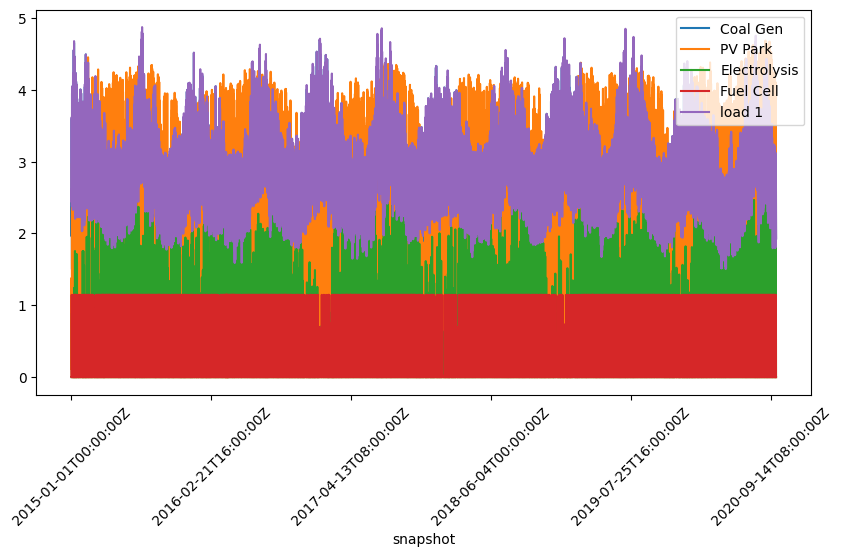

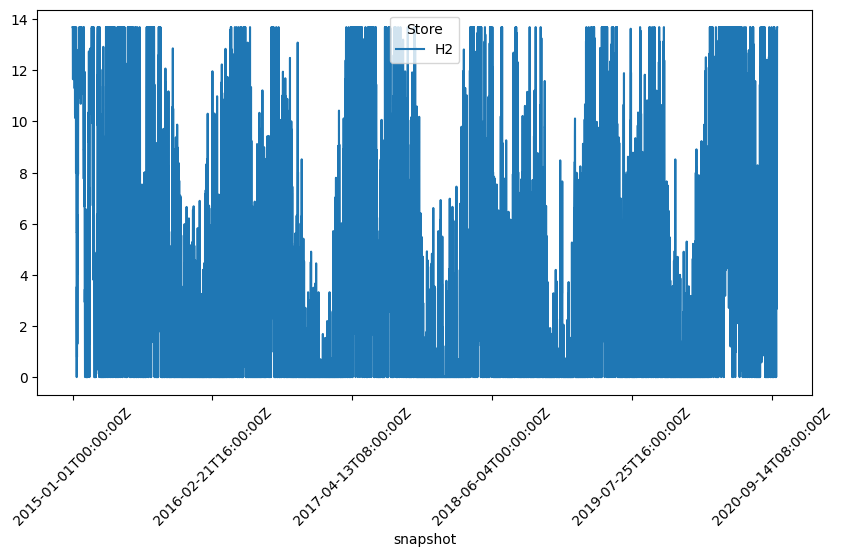

In [13]:
df=pd.concat([network.generators_t.p, network.links_t.p0, network.loads_t.p],axis=1)
df.plot(rot=45)
network.stores_t.e.plot(rot=45)

Στις παρακάτω γραφικές μπορούμε να δούμε την απόκριση του συστηματος για το διάστημα **'2020-07-22':'2020-07-25'**.\
Μπορούμε να παρατηρήσουμε ότι τα μεσημέρια η γεννήτρια (μπλε) λειτουγεί στην ελάχιστη ισχύ της και το ΦΒ πάρκο (πορτοκαλί) παράγει στο μέγιστο, ενώ ένα μέρος αυτής της ενέργεια που περισσεύει χρησιμοποιείται για ηλεκτρόλυση (πράσινο). Από τη δεύτερη γραφική φαίνεται ότι όσο ο ηλεκτρολύτης δουλεύει το απόθεμα ενέργειας υδρογόνου στο store αυξάνεται.\
Τα βράδια παρατηρούμε ότι δεν υπάρχει ΦΒ παραγωγή και χρησιμοποιείται η κυψέλη καυσίμου για να δώσει ενέργεια στο δίκτυο οπότε το απόθεμα υδρογόνου στο store μειώνεται. Το υπόλοιπο της ενέργειας που απαιτείται για να καλυφθεί το φορτίο παράγεται από την γεννήτρια diesel.

<Axes: xlabel='snapshot'>

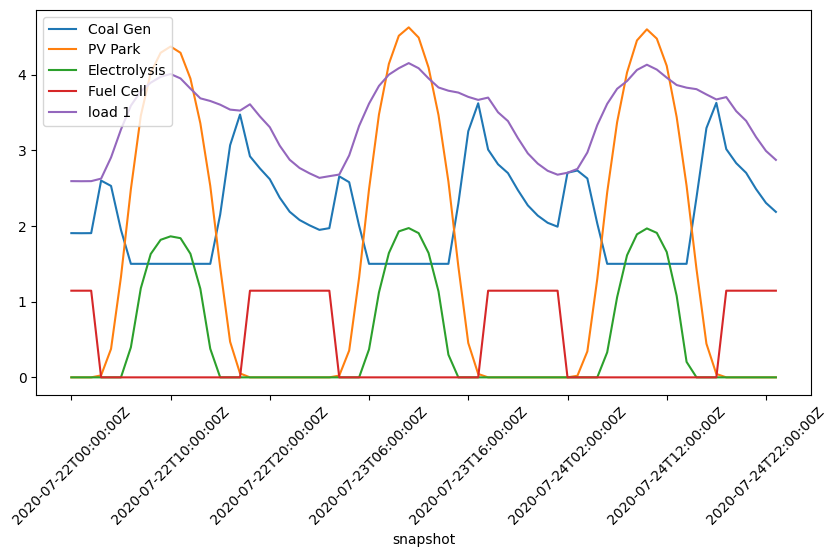

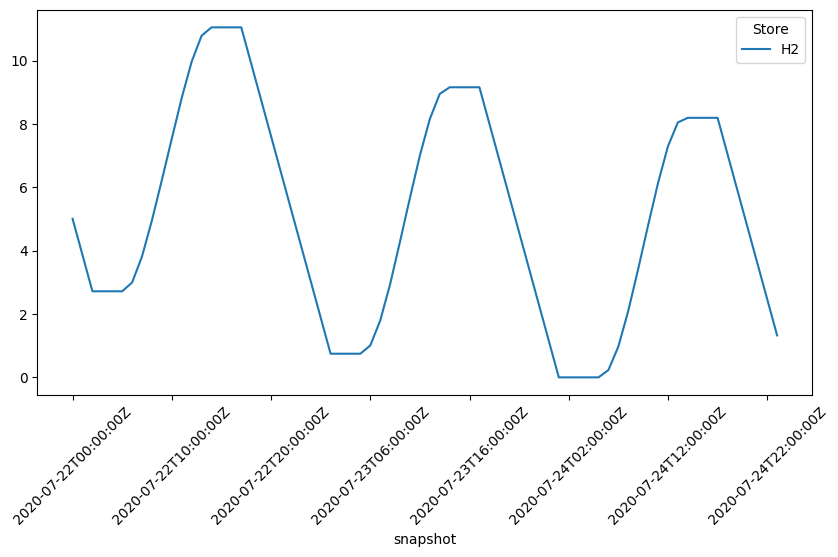

In [12]:
df['2020-07-22':'2020-07-25'].plot(rot=45)
network.stores_t.e['2020-07-22':'2020-07-25'].plot(rot=45)